In [1]:
import networkx as nx 
from networks.cycle import cycle_net
import numpy as np
import random

from environements.random import RandomEnvironement

from agents.greed_routing_agent import GreedyNeighborsAgent
from agents.shortest_path import ShortestPathAgent
from agents.mcts.agent import MCTSAgent

import matplotlib.pyplot as plt

In [2]:
def run_experiment(env, agent, epochs):

    state = env._state
    sender = env._sender
    reciever = env._reciever
    success = False
    LOG = []

    LOG.append(
            {
                "sender":sender,
                "reciever":reciever,
                "action":None,
                "rewards":0
            }
        ) 

    r = 0
    for __ in range(epochs):
        # Compute action through Agent's policy
        if __ == 0:
            action = agent.run(state= state, sender= sender, reciever= reciever)
        else:
            action = agent.run(state= state, sender= sender, reciever= reciever, reward= result.reward, success=success)

        # State evolution and compute reward
        result = env.run(action= action)
        
        # Update parameters
        state = result.state
        sender = result.sender
        reciever = result.reciever
        success = result.success
        
        r += result.reward

        LOG.append(
            {
                "sender":sender,
                "reciever":reciever,
                "action":action,
                "rewards":r
            }
        )
    return LOG
    
def gsr_events(C,N):

    paths = []
    nodes = list(C.nodes)
    for n in nodes:
        nodes.remove(n)
        for t in nodes:
            try:
                paths.append(list(nx.all_simple_paths(C, source=n, target=t)))
            except:
                pass
    paths = [j for i in paths for j in i]

    v = np.random.rand(len(paths))
    prob_dist = v / np.linalg.norm(v)

    sr_events = []
    for __ in range(N):
        path = random.choices(paths, prob_dist)[0]
        sr_events.append((path[0], path[-1]))

    return sr_events

In [20]:
def benchmark(C,Q,sr_events):

    ben = {}
    agents = ["greedy", "shortest path", "MCTS"]

    #### Greedy
    env = RandomEnvironement(physical_network = C, 
                                    virtual_network = Q,
                                    sender_reciever_events= sr_events)

    agent = GreedyNeighborsAgent(physical_network= C, virtual_network = Q)

    LOG = run_experiment(env, agent, epochs=epochs)
    ben["greedy"] = LOG    

    #### Shortest Path
    env = RandomEnvironement(physical_network = C, 
                                    virtual_network = Q,
                                    sender_reciever_events= sr_events)

    agent = ShortestPathAgent(physical_network= C,
                    virtual_network = Q)

    LOG = run_experiment(env, agent, epochs=epochs)
    ben["shortest path"] = LOG

    #### MCTS
    env = RandomEnvironement(physical_network = C, 
                                virtual_network = Q,
                                sender_reciever_events= sr_events)

    mcts_sim = 200
    c_ucb1 = 2
    agent = MCTSAgent(physical_network= C,
                    virtual_network = Q,
                    # prob_dist = prob_dist,
                    sender_reciever_events= sr_events,
                    N = mcts_sim,
                    c = c_ucb1)

    LOG = run_experiment(env, agent, epochs=epochs)
    ben["MCTS"] = LOG

    draw = False
    ben["winner"] = agents[0]
    for a in agents[1:]:
        if ben[ben["winner"]][-1]["rewards"] < ben[a][-1]["rewards"]:
            draw = False
            ben["winner"] = a
        elif ben[ben["winner"]][-1]["rewards"] == ben[a][-1]["rewards"]:
            draw = True

    if draw:
        ben["winner"]="draw"
    return ben


In [30]:
n=16
dth=4
epochs=50
N_events=epochs
N_ben = 50

C, Q = cycle_net(n=n, dth=dth)
data = []
win = []

for __ in range(N_ben):

    sr_events = gsr_events(C,N_events)
    ben = benchmark(C,Q,sr_events)
    data.append(ben)
    win.append(ben["winner"])


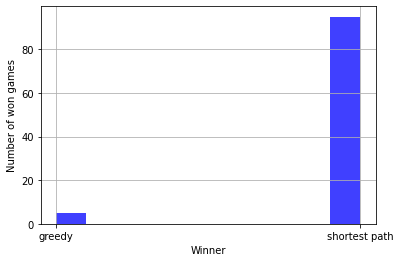

In [ ]:
plt.hist(win, density=False, facecolor='b', alpha=0.75)

plt.xlabel('Winner')
plt.ylabel('Number of won games')
plt.grid(True)
plt.show()

In [27]:
winGvMCTS = []

for ben in data:
    if ben["greedy"][-1]["rewards"] < ben["MCTS"][-1]["rewards"]:
        winGvMCTS.append("MCTS")
    elif ben["greedy"][-1]["rewards"] == ben["MCTS"][-1]["rewards"]:
        winGvMCTS.append("draw")
    else:
        winGvMCTS.append("greedy")
    

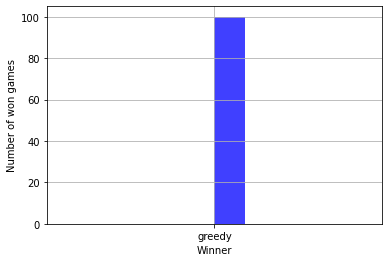

In [28]:
plt.hist(winGvMCTS, density=False, facecolor='b', alpha=0.75)

plt.xlabel('Winner')
plt.ylabel('Number of won games')
plt.grid(True)
plt.show()